In [1]:
import numpy as np
import pandas as pd

import sklearn as sk
import matplotlib.pyplot as plt
#from obspy import Stream, Trace, UTCDateTime
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import pylab as pl
from keras.callbacks import ModelCheckpoint

import keras

from keras.layers import Activation, Conv1D, Dense, Dropout, Flatten, MaxPooling3D, BatchNormalization, InputLayer, LSTM
from keras.layers import Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.utils import Sequence
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import ParameterGrid
import re
from sklearn.metrics import confusion_matrix

import os
import sys
classes_dir = 'D:\Thesis_ssd\MasterThesis3.0'
os.chdir(classes_dir)
from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.DataGenerator import DataGenerator
from Classes.DataProcessing.NoiseAugmentor import NoiseAugmentor
from Classes.DataProcessing.TimeAugmentor import TimeAugmentor
from Classes.Modeling.DynamicModels import DynamicModels
from Classes.Modeling.CustomCallback import CustomCallback
from Classes.Scaling.ScalerFitter import ScalerFitter
from Classes.Scaling.MinMaxScalerFitter import MinMaxScalerFitter
from Classes.Scaling.StandardScalerFitter import StandardScalerFitter
from Classes import Tf_shutup
Tf_shutup.Tf_shutup()

from livelossplot import PlotLossesKeras

import tensorflow as tf

from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams["figure.figsize"]= (15,15)
helper = HelperFunctions()

import sys
ISCOLAB = 'google.colab' in sys.modules

import random
import pprint

base_dir = 'D:\Thesis_ssd\MasterThesis3.0'
os.chdir(base_dir)

Using TensorFlow backend.


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

#tf.debugging.set_log_device_placement(True)

Found GPU at: /device:GPU:0


In [3]:
### Data conditions: ###
load_args = {
    'earth_explo_only' : False,
    'noise_earth_only' : False,
    'noise_not_noise' : True,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 0.3,
    'seed' : 1,
    'subsample_size' : 0.2,
    'balance_non_train_set' : True,
    'use_true_test_set' : False
}

loadData = LoadData(**load_args)

full_ds, train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)
dataGen = DataGenerator(loadData)

if load_args['earth_explo_only']:
    full_and_noise_ds = np.concatenate((full_ds, noise_ds))
    timeAug = TimeAugmentor(handler, full_and_noise_ds, seed = load_args['seed'])
else:
    timeAug = TimeAugmentor(handler, full_ds, seed = load_args['seed'])

In [4]:
print(len(train_ds), len(val_ds), len(test_ds))
classes, counts = handler.get_class_distribution_from_ds(full_ds)
print("Nr noise samples " + str(len(loadData.noise_ds)))

16926 3385 2258
Total: 22569, earthquake: 7503, explosion: 7316, noise: 7750
Nr noise samples 5787


In [5]:
noise_ds.shape

(5787, 3)

In [10]:
############ Model picker #############
model_nr_type = "LSTM"
is_lstm = True
num_layers = 1
decay_sequence = [1]
use_layerwise_dropout_batchnorm = True

########### Hyperparameters ###########
batch_size = 1024
epochs = 30
learning_rate = 0.05
opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, clipnorm=1.0, clipvalue=0.5)
#opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
activation = 'tanh'
output_layer_activation = 'sigmoid'
dropout_rate = 0.3
filters = 17
kernel_size = 5
l1_r = 0.00001
l2_r = 0.0001
padding = 'same'
start_neurons = 32
num_channels = 3

########### Preprocessing ###########
use_noise_augmentor = True
use_time_augmentor = True
detrend = False
use_scaler = True
use_highpass = False
highpass_freq = 0.2

use_tensorboard = False
use_livelossplot = True
use_custom = False



In [11]:
def clear_tensorboard_dir():
    import os
    import shutil
    path = f"{base_dir}/Tensorboard_dir/fit"
    files = os.listdir(path)
    print(files)
    for f in files:
        shutil.rmtree(os.path.join(path,f))

callbacks = []
if use_tensorboard:
    import datetime
    clear_tensorboard_dir()
    %load_ext tensorboard
    %tensorboard --logdir tensorboard_dir/fit
    log_dir = f"{base_dir}/tensorboard_dir/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    callbacks.append(tensorboard_ballback)

if use_custom:
    custom_callback = CustomCallback(data_gen)
    callbacks.append(custom_callback)
elif use_livelossplot:
    callbacks.append(PlotLossesKeras())

In [12]:
num_ds, channels, timesteps = dataGen.get_trace_shape_no_cast(train_ds, use_time_augmentor)
input_shape = (batch_size, channels, timesteps)

build_model_args ={"model_type" : model_nr_type,
                    "num_layers": num_layers,
                    "input_shape" : (batch_size, channels, timesteps),
                    "num_classes" : len(set(loadData.label_dict.values())),
                    "dropout_rate" : dropout_rate,
                    "activation" : activation,
                    "output_layer_activation" : output_layer_activation,
                    "l2_r" : l2_r,
                    "l1_r" : l1_r,
                    "full_regularizer" : True,
                    "start_neurons" : start_neurons,
                    "decay_sequence" : decay_sequence,
                    "filters" : filters,
                    "kernel_size" : kernel_size,
                    "padding" : padding,
                    "use_layerwise_dropout_batchnorm" : use_layerwise_dropout_batchnorm}
model = DynamicModels(**build_model_args).model


model_args = {'loss' : "binary_crossentropy",
              'optimizer' : opt,
              'metrics' : [tf.keras.metrics.Precision(thresholds=None, top_k=None, class_id=None, name=None, dtype=None), 
                           tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5),
                           tf.keras.metrics.Recall(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)]}
                           

model.compile(**model_args)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (1024, 6000, 32)          4608      
_________________________________________________________________
dropout_2 (Dropout)          (1024, 6000, 32)          0         
_________________________________________________________________
batch_normalization_2 (Batch (1024, 6000, 32)          128       
_________________________________________________________________
flatten_2 (Flatten)          (1024, 192000)            0         
_________________________________________________________________
dense_2 (Dense)              (1024, 1)                 192001    
Total params: 196,737
Trainable params: 196,673
Non-trainable params: 64
_________________________________________________________________


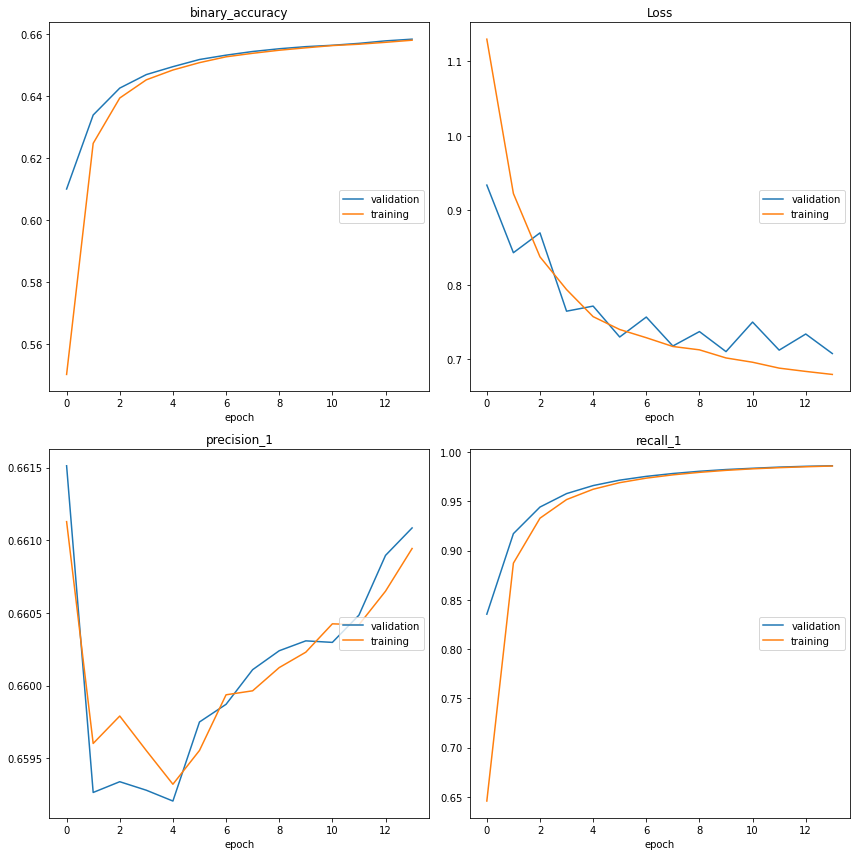

binary_accuracy
	validation       	 (min:    0.610, max:    0.658, cur:    0.658)
	training         	 (min:    0.550, max:    0.658, cur:    0.658)
Loss
	validation       	 (min:    0.708, max:    0.934, cur:    0.708)
	training         	 (min:    0.680, max:    1.130, cur:    0.680)
precision_1
	validation       	 (min:    0.659, max:    0.662, cur:    0.661)
	training         	 (min:    0.659, max:    0.661, cur:    0.661)
recall_1
	validation       	 (min:    0.835, max:    0.986, cur:    0.986)
	training         	 (min:    0.646, max:    0.986, cur:    0.986)
Epoch 15/30
13/16 [=======================>......] - ETA: 7s - loss: 0.6714 - precision_1: 0.6613 - binary_accuracy: 0.6587 - recall_1: 0.9864

In [ ]:
scaler = None
noiseAug = None
if use_time_augmentor:
    timeAug.fit()
if use_scaler:
    scaler = StandardScalerFitter(train_ds, timeAug).fit_scaler(detrend = detrend)
if use_noise_augmentor:
    noiseAug = NoiseAugmentor(train_ds, use_scaler, scaler, loadData, timeAug)

    
    

gen_args = {"num_channels" : num_channels,
            "batch_size" : batch_size,
            "detrend" : detrend,
            "use_scaler" : use_scaler,
            "scaler" : scaler,
            "use_time_augmentor": use_time_augmentor,
            "timeAug" : timeAug,
            "use_noise_augmentor" : use_noise_augmentor,
            "noiseAug" : noiseAug,
            "use_highpass" : use_highpass,
            "highpass_freq" : highpass_freq,
            "is_lstm" : is_lstm}


train_gen = dataGen.data_generator(train_ds, **gen_args)
val_gen = dataGen.data_generator(val_ds, **gen_args)
test_gen = dataGen.data_generator(test_ds, **gen_args)



args = {'steps_per_epoch' : helper.get_steps_per_epoch(train_ds, batch_size),
        'epochs' : epochs,
        'validation_data' : val_gen,
        'validation_steps' : helper.get_steps_per_epoch(val_ds, batch_size),
        'verbose' : 1,
        'use_multiprocessing' : False, 
        'workers' : 1,
        'callbacks' : callbacks
}

model_fit = model.fit(train_gen, **args)

In [ ]:
helper.evaluate_model(model, test_gen, test_ds, batch_size, handler.label_dict)